# [개념 필사]

## CHAPTER 07 <앙상블 학습과 랜덤 포레스트>

> 앙상블 학습 - 가장 좋은 모델 "1개" 보다 더 나은 예측을 얻을 수 있음 (대중의 지혜, 앙상블 방법) / 1개의 예측기보다 편향은 비슷하지만 분산 감소. (결정 경계 덜 불규칙적)


## **7.5 부스팅**

◾**부스팅**: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법. 앞 모델들을 보완해나가는 방향.

## 7.5.1 에이다부스트 (Adaptive Boosting)

💡 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이기 (가중치 업데이트). 새로운 예측기는 학습이 어려운 샘플에 점점 적합하게 됨.

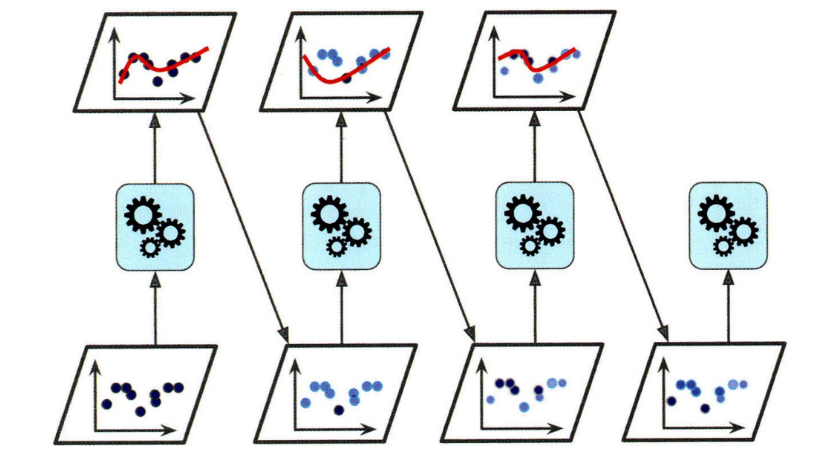

* 모든 예측기의 훈련 끝 -> 배깅, 페이스팅과 비슷하게 최종 예측.

* 연속된 학습 기법의 단점: 이전 예측기의 훈련, 평가가 완료된 후 다음 과정이 이루어지므로 병렬화(분할) 불가능!!

* 예측기가 정확할수록 가중치 증가. 무작위 추측은 0. 그것보다 나쁘다면 음수.

* 최종 예측기가 업데이트된 가중치를 사용해 훈련 => 전체 과정 반복.

* 지정된 예측기 수에 도달하거나 완벽한 예측기 만들어지면 중지.

* 가중치 합이 가장 큰 클래스가 예측결과.

🖥 SAMME (에이다부스트 다중 클래스 버전)

🖥 SAMME.R (predict_proba() 가능 시) (일반적으로 성능 굿)

🖥 AdaBoostClassifier (AdaBoostRegressor)


## 7.5.2 그레이디언트 부스팅

💡 에이다부스트와 달리, 샘플의 가중치 수정 대신 이전 예측기가 만든 잔여 오차에 새로운 예측기 학습.

* 그레이디언트 트리 부스팅, 그레이디언트 부스티드 회귀 트리 (GBRT)

* 잔여오차를 학습한 트리가 앙상블에 추가될수록 성능 증가.

🖥 GradientBoostingRegressor
```
n_estimators - 트리 수

max_depth

min_samples_leaf

learning_rate - 각 트리의 기여 정도
```

* 축소: learning_rate를 낮게 설정하여 훈련 세트 학습에 많은 트리를 요청시키는 규제 방법 (성능은 증가, 과대적합)

```
staged_predict() - 간단하게 최적의 트리 수 찾기. 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자 반환.

warm_stat=True - fit() 호출 시 기존 트리 유지

subsample - 각 트리가 훈련할 때 사용할 훈련 샘플 비율 지정 (확률적 그레이디언트 부스팅)
```
🖥 XGBoost 파이썬 라이브러리 - 최적화된 그레이디언트 부스팅 구현


## **7.6 스태킹**

💡 앙상블에 속한 모든 예측기의 예측을 취합하는 함수 대신, 취합하는 모델을 훈련시키기.

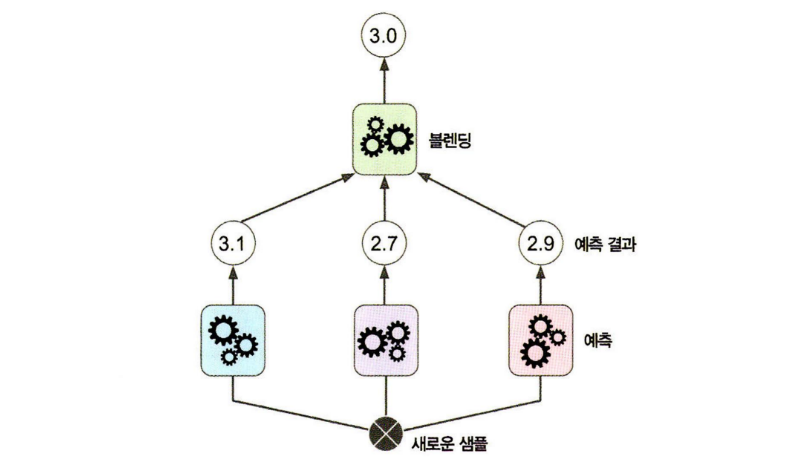

* 마지막 예측기: 블렌더, 메타학습기

* 블렌더 학습시키는 일반적인 방법: 홀드 아웃 세트 사용

* 사이킷런, 스태킹 직접 지원 X


# [코드 필사]

In [1]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

# 5장에서의 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [2]:
## 에이다부스트

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, # max_depth=1 결정노드1개, 리프노드2개 (디폴트)
    algorithm="SAMME", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [3]:
## 1. 훈련세트에 결정트리회귀 학습

from sklearn.tree import DecisionTreeClassifier

tree_reg1 = DecisionTreeClassifier(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeClassifier(max_depth=2)

In [4]:
## 2. 첫번째 예측기의 잔여 오차에 두번째 결정 트리 훈련

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeClassifier(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeClassifier(max_depth=2)

In [5]:
## 3. 두번째 예측기의 잔여 오차에 세번째 결정 트리 훈련

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeClassifier(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeClassifier(max_depth=2)

In [6]:
## 새로운 샘플에 대한 예측 = 모든 트리(3개)의 예측 더하기.

# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [7]:
## 사이킷런 GradientBoostingRegressor로 동일한 앙상블 만들기

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [8]:
## 120개 트리 GBRT, 각 단계에서 검증 오차 측정

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

# 최적의 트리수로 새로운 GBRT 훈련
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(120))

In [9]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [10]:
## XGBoost

import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [11]:
xgb_reg = xgboost.XGBRegressor(early_stopping_rounds=2)
xgb_reg.fit(X_train, y_train,
            eval_set = [(X_val, y_val)])
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.37168
[1]	validation_0-rmse:0.29451
[2]	validation_0-rmse:0.22604
[3]	validation_0-rmse:0.17509
[4]	validation_0-rmse:0.13866
[5]	validation_0-rmse:0.11581
[6]	validation_0-rmse:0.09671
[7]	validation_0-rmse:0.08364
[8]	validation_0-rmse:0.07771
[9]	validation_0-rmse:0.07390
[10]	validation_0-rmse:0.07145
[11]	validation_0-rmse:0.06874
[12]	validation_0-rmse:0.06786
[13]	validation_0-rmse:0.06731
[14]	validation_0-rmse:0.06654
[15]	validation_0-rmse:0.06603
[16]	validation_0-rmse:0.06565
[17]	validation_0-rmse:0.06536
[18]	validation_0-rmse:0.06517
[19]	validation_0-rmse:0.06500
[20]	validation_0-rmse:0.06488
[21]	validation_0-rmse:0.06509
[22]	validation_0-rmse:0.06517
